In [29]:
### Backup Steps

### Backup Data

In [ ]:
PROJECT_ID="xxx"
LOCATION="xxx"
BIGQUERY_CONNECTION_REGION="us-central1"
BIGQUERY_CONNECTION_NAME="veospark_bq_embedding_conn"
BIGQUERY_MODEL_NAME="multimodal_embedding_model"
BIGQUERY_DATASET="xxxx"

In [ ]:
# Run below SQL on BigQuery Console
print(f"""

CREATE TABLE `{PROJECT_ID}.{BIGQUERY_DATASET}.imagen_history_backup` AS SELECT * FROM `{PROJECT_ID}.{BIGQUERY_DATASET}.imagen_history`;
CREATE TABLE `{PROJECT_ID}.{BIGQUERY_DATASET}.veo_history_backup` AS SELECT * FROM `{PROJECT_ID}.{BIGQUERY_DATASET}.veo_history`;
CREATE TABLE `{PROJECT_ID}.{BIGQUERY_DATASET}.image_enrichment_history_backup` AS SELECT * FROM `{PROJECT_ID}.{BIGQUERY_DATASET}.image_enrichment_history`;

""")

In [ ]:
!bq update --schema ../src/backend/schemas/imagen_history.json {PROJECT_ID}:{BIGQUERY_DATASET}.imagen_history
!bq update --schema ../src/backend/schemas/veo_history.json {PROJECT_ID}:{BIGQUERY_DATASET}.veo_history
!bq update --schema ../src/backend/schemas/image_enrichment_history.json {PROJECT_ID}:{BIGQUERY_DATASET}.image_enrichment_history

### Step 0 - Setup Dependencies and Variables

In [ ]:
!pip install -U google-genai

In [ ]:
PROJECT_ID="xxx"
LOCATION="xxx"
BIGQUERY_CONNECTION_REGION="us-central1"
BIGQUERY_CONNECTION_NAME="veospark_bq_embedding_conn"
BIGQUERY_MODEL_NAME="multimodal_embedding_model"
BIGQUERY_DATASET="xxxx"

### Step 1 - Create BigQuery Connection - Allowing BigQuery to invoke Embedding Model from Vertex AI

```
bq mk --connection --location=us-central1 --project_id=genai-dnb-demo \
    --connection_type=CLOUD_RESOURCE bq_embedding_conn
```





In [ ]:
!bq mk --connection --location={BIGQUERY_CONNECTION_REGION} --project_id={PROJECT_ID} --connection_type=CLOUD_RESOURCE {BIGQUERY_CONNECTION_NAME}

In [ ]:
!bq show --connection {PROJECT_ID}.{BIGQUERY_CONNECTION_REGION}.{BIGQUERY_CONNECTION_NAME}

#### 👆 Service account needs to add `Vertex AI User` permission, on IAM Console

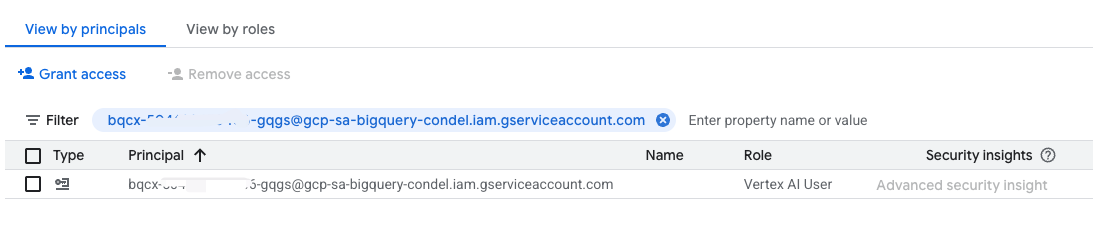

### Step 2 - Create MODEL & Functions in BigQuery

Options:
> 1. __RUN Commands in BigQuery Console__
> 2. Use __BigQuery Magic Commands__


Below uses #1 - Run In BigQuery Console

#### A - Create Embedding Model Entrypoint in BigQuery

In [ ]:
print( f"""CREATE OR REPLACE MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_MODEL_NAME}`
  REMOTE WITH CONNECTION `{PROJECT_ID}.{BIGQUERY_CONNECTION_REGION}.{BIGQUERY_CONNECTION_NAME}`
  OPTIONS (
    endpoint = 'multimodalembedding@001'
  );""")


#### B - Create TABLE FUNCTIONS in BigQuery

> Table Functions will utilize the mebdding model to perform vector creation and comparison.


__*Generate below SQL and run in BigQuery Console*__

In [ ]:
print(f"""
### IMAGEN_HISTORY
CREATE OR REPLACE TABLE FUNCTION `{PROJECT_ID}.{BIGQUERY_DATASET}.FindSimilarImages_ImagenHistory` (
  query_text STRING,
  user_email STRING,
  top_k INT64
)
RETURNS TABLE<
    user_email STRING,
    trigger_time TIMESTAMP,
    completion_time TIMESTAMP,
    prompt STRING,
    model_used STRING,
    aspect_ratio STRING,
    output_image_gcs_path STRING,
    status STRING,
    resolution STRING,
    creative_project_id STRING,
    error_message STRING,
    operation_duration FLOAT64,
    similarity FLOAT64
>
AS (
  WITH QueryEmbedding AS (
    -- Step A: Generate the embedding for the input text.
    SELECT ml_generate_embedding_result as text_embedding
    FROM ML.GENERATE_EMBEDDING(
      MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_MODEL_NAME}`,
      (SELECT query_text AS content)
    )
  )
  -- Step B: Run the main search query.
  SELECT
    base.*,
    -- Step C: Calculate cosine similarity.
    1 - ML.DISTANCE(base.image_embedding, QueryEmbedding.text_embedding, 'COSINE')/2 AS similarity
  FROM
    `{PROJECT_ID}.{BIGQUERY_DATASET}.imagen_history` AS base
  -- Step D: Make the text embedding available to every row.
  CROSS JOIN
    QueryEmbedding
  WHERE base.status = 'SUCCESS' AND base.user_email = user_email
  -- Step E: Filter for the top K results using QUALIFY. This must come BEFORE the final ORDER BY.
  -- The ORDER BY inside the OVER() clause determines the ranking.
  QUALIFY ROW_NUMBER() OVER (ORDER BY similarity DESC) <= top_k
  -- Step F: The final ORDER BY sorts the filtered output for presentation.
  ORDER BY
    similarity DESC
);""")



### GEMINI_2.5_FLASH_IMAGE_HISTORY
print(f"""
CREATE OR REPLACE TABLE FUNCTION `{PROJECT_ID}.{BIGQUERY_DATASET}.FindSimilarImages_EnrichmentHistory` (
  query_text STRING,
  user_email STRING,
  top_k INT64
)
RETURNS TABLE<
    user_email STRING,
    trigger_time TIMESTAMP,
    completion_time TIMESTAMP,
    prompt STRING,
    model_used STRING,
    aspect_ratio STRING,
    output_image_gcs_path STRING,
    status STRING,
    resolution STRING,
    creative_project_id STRING,
    error_message STRING,
    operation_duration FLOAT64,
    similarity FLOAT64
>
AS (
  WITH QueryEmbedding AS (
    -- Step A: Generate the embedding for the input text.
    SELECT ml_generate_embedding_result as text_embedding
    FROM ML.GENERATE_EMBEDDING(
      MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_MODEL_NAME}`,
      (SELECT query_text AS content)
    )
  )
  -- Step B: Run the main search query.
  SELECT
    base.*,
    -- Step C: Calculate cosine similarity.
    1 - ML.DISTANCE(base.image_embedding, QueryEmbedding.text_embedding, 'COSINE')/2 AS similarity
  FROM
    `{PROJECT_ID}.{BIGQUERY_DATASET}.image_enrichment_history` AS base
  -- Step D: Make the text embedding available to every row.
  CROSS JOIN
    QueryEmbedding
  WHERE base.status = 'SUCCESS' AND base.user_email = user_email
  -- Step E: Filter for the top K results using QUALIFY. This must come BEFORE the final ORDER BY.
  -- The ORDER BY inside the OVER() clause determines the ranking.
  QUALIFY ROW_NUMBER() OVER (ORDER BY similarity DESC) <= top_k
  -- Step F: The final ORDER BY sorts the filtered output for presentation.
  ORDER BY
    similarity DESC
);""")


### VEO_HISTORY
print(f"""
CREATE OR REPLACE TABLE FUNCTION `{PROJECT_ID}.{BIGQUERY_DATASET}.FindSimilarVideos_VeoHistory` (
  query_text STRING,
  user_email STRING,
  top_k INT64
)
RETURNS TABLE<
    user_email STRING,
    trigger_time TIMESTAMP,
    completion_time TIMESTAMP,
    prompt STRING,
    model_used STRING,
    aspect_ratio STRING,
    output_video_gcs_paths STRING,
    video_duration INTEGER,
    status STRING,
    resolution STRING,
    creative_project_id STRING,
    error_message STRING,
    operation_duration FLOAT64,
    similarity FLOAT64
>
AS (
  WITH QueryEmbedding AS (
    -- Step A: Generate the embedding for the input text.
    SELECT ml_generate_embedding_result as text_embedding
    FROM ML.GENERATE_EMBEDDING(
      MODEL `{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_MODEL_NAME}`,
      (SELECT query_text AS content)
    )
  )
  -- Step B: Run the main search query.
  SELECT
    base.*,
    -- Step C: Calculate cosine similarity.
    1 - ML.DISTANCE(base.video_embedding, QueryEmbedding.text_embedding, 'COSINE')/2 AS similarity
  FROM
    `{PROJECT_ID}.{BIGQUERY_DATASET}.veo_history` AS base
  -- Step D: Make the text embedding available to every row.
  CROSS JOIN
    QueryEmbedding
  WHERE base.status = 'SUCCESS' AND base.user_email = user_email
  -- Step E: Filter for the top K results using QUALIFY. This must come BEFORE the final ORDER BY.
  -- The ORDER BY inside the OVER() clause determines the ranking.
  QUALIFY ROW_NUMBER() OVER (ORDER BY similarity DESC) <= top_k
  -- Step F: The final ORDER BY sorts the filtered output for presentation.
  ORDER BY
    similarity DESC
);""")

### Step 3 - Generate Emebdding for existing BQ table data

### For Images

> Needs to run twice for `imagen_history` and `image_enrichment_history` table.

In [ ]:
import vertexai
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from google.cloud import bigquery
from google import genai
from google.genai import types
from google.api_core import exceptions as google_api_exceptions
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
import time
import ast

# ==============================================================================
# Configuration
# ==============================================================================
# PROJECT_ID = "xxx"
# LOCATION = "xxx"
# BIGQUERY_DATASET = "xxx"
BIGQUERY_TABLE = "image_enrichment_history" # and "imagen_history"
GEMINI_MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
MAX_WORKERS = 10

# This client is correctly initialized for the way it's used in process_image
genai_client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location='global' # Gemini API location is often global
)

# Define the columns that form a unique key for a row.
# This is crucial for accurately updating the DataFrame in memory.
UNIQUE_ID_COLUMNS = [
    "user_email",
    "trigger_time",
    "prompt",
    "operation_duration",
    "creative_project_id",
    "output_image_gcs_path"
]

# ==============================================================================
# Helper Function for ML Tasks
# ==============================================================================
def process_image(
    gcs_uri: str,
    embedding_model: MultiModalEmbeddingModel
) -> dict:
    """
    Generates a description and embeddings for a single image.
    This function is focused only on the ML task and returns the results.
    """
    print(f"Starting to process image: {gcs_uri}")

    if not isinstance(gcs_uri, str) or not gcs_uri.startswith("gs://"):
        raise ValueError(f"Invalid GCS URI provided: '{gcs_uri}'")

    description = ""
    try:

        # 1. Generate Description
        print(f"Generating description for {gcs_uri} using model {GEMINI_MODEL_NAME}.")
        image_part = types.Part.from_uri(file_uri=gcs_uri, mime_type="image/jpeg")
        description_prompt = "Describe this image in detail. Focus on the main subjects, background, style, colors, mood and overall description. Output within 200 words"

        response = genai_client.models.generate_content(
            model=GEMINI_MODEL_NAME,
            contents=[description_prompt, image_part]
        )
        description = response.text.strip()
        print(f"Successfully generated description for {gcs_uri}.")

    except (google_api_exceptions.GoogleAPICallError, ValueError) as e:
        print(f"Failed to generate description for {gcs_uri}. Error: {e}")
        raise

    try:
        # 2. Generate Embeddings
        print(f"Generating embeddings for {gcs_uri}.")
        embeddings = embedding_model.get_embeddings(
            image=Image.load_from_file(gcs_uri),
            contextual_text=description[:1000] # Ensure text is within model limits
        )
        print(f"Successfully generated embeddings for {gcs_uri}.")

        return {
            "description": description, # Return the new description as well
            "desc_embedding": embeddings.text_embedding,
            "image_embedding": embeddings.image_embedding,
        }

    except (google_api_exceptions.GoogleAPICallError, ValueError) as e:
        print(f"Failed to generate embeddings for {gcs_uri}. Error: {e}")
        raise


# ==============================================================================
# Main Orchestration Logic
# ==============================================================================
def generate_and_overwrite_embeddings():
    """
    Reads a full table, processes rows needing updates in memory,
    and overwrites the entire table with the modified data.

    WARNING: This operation is not safe for concurrent writes. It will delete
    any new data added to the table while this script is running.
    """
    start_time = time.time()
    print("--- Starting Embedding Generation and Overwrite Script ---")
    try:
        # --- Log all configuration parameters ---
        print("Configuration:")
        print(f"  PROJECT_ID: {PROJECT_ID}")
        print(f"  LOCATION: {LOCATION}")
        print(f"  BIGQUERY_DATASET: {BIGQUERY_DATASET}")
        print(f"  BIGQUERY_TABLE: {BIGQUERY_TABLE}")
        print(f"  GEMINI_MODEL_NAME: {GEMINI_MODEL_NAME}")
        print(f"  MAX_WORKERS: {MAX_WORKERS}")

        print("Initializing clients and models...")
        vertexai.init(project=PROJECT_ID, location=LOCATION)
        bq_client = bigquery.Client(project=PROJECT_ID)
        embedding_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")
        table_id = f"{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"
        print("Initialization complete.")

        # --- STEP 1: Read the ENTIRE table into a pandas DataFrame ---
        print(f"Reading full table `{table_id}` into memory...")
        read_start_time = time.time()
        full_df = bq_client.query(f"SELECT * FROM `{table_id}`").to_dataframe()
        print(f"Successfully loaded {len(full_df)} total rows in {time.time() - read_start_time:.2f} seconds.")

        # --- STEP 2: Identify which rows need to be processed ---
        print("Filtering for rows that require processing...")
        # A row needs processing if either embedding is missing, status is SUCCESS, and a valid GCS path exists.
        rows_to_process_df = full_df[
            ((full_df['desc_embedding'].apply(len) == 0) | (full_df['image_embedding'].apply(len) == 0)) &
            (full_df['status'] == 'SUCCESS') &
            (full_df['output_image_gcs_path'].str.startswith('gs://', na=False))
        ]

        if rows_to_process_df.empty:
            print("No rows found that require embedding generation. Exiting.")
            return

        total_to_process = len(rows_to_process_df)
        print(f"Found {total_to_process} rows to process.")

        processed_data = []
        failed_items = []
        # --- Added MAX_WORKERS to the log message ---
        print(f"Starting concurrent processing with up to {MAX_WORKERS} workers...")
        processing_start_time = time.time()

        # --- STEP 3: Process only the necessary rows concurrently ---
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            future_to_row = {
                executor.submit(process_image, row.output_image_gcs_path, embedding_model): row
                for _, row in rows_to_process_df.iterrows()
            }

            processed_count = 0
            for future in as_completed(future_to_row):
                processed_count += 1
                original_row = future_to_row[future]
                gcs_uri = original_row.get("output_image_gcs_path", "")
                try:
                    result = future.result()

                    # Create a record that includes the unique keys AND the new data
                    update_record = {key: original_row[key] for key in UNIQUE_ID_COLUMNS}
                    # Also update the description field if it's in your schema
                    # update_record['description'] = result['description']
                    update_record['desc_embedding'] = result['desc_embedding']
                    update_record['image_embedding'] = result['image_embedding']
                    processed_data.append(update_record)
                    # ---  Added progress tracking and specific GCS URI ---
                    print(f"Progress: {processed_count}/{total_to_process}. Successfully processed {gcs_uri}")

                except Exception as e:
                    failed_items.append(gcs_uri)
                    # --- Log exception with full traceback for debugging ---
                    print(f'Progress: {processed_count}/{total_to_process}. FAILED to process {gcs_uri}. Error {e}')

        processing_duration = time.time() - processing_start_time
        print(f"--- Processing complete in {processing_duration:.2f} seconds ---")
        print(f"Summary: {len(processed_data)} succeeded, {len(failed_items)} failed.")

        if not processed_data:
            print("No embeddings were successfully generated. Exiting without table update.")
            return

        # --- STEP 4: Modify the main DataFrame in memory with the new data ---
        print(f"Updating {len(processed_data)} rows in the main DataFrame...")

        updates_df = pd.DataFrame(processed_data)

        # Set unique keys as index for alignment. Ensure the 'description' column exists in full_df.
        if 'description' not in full_df.columns:
            full_df['description'] = '' # Add column if it doesn't exist
        full_df.set_index(UNIQUE_ID_COLUMNS, inplace=True)
        updates_df.set_index(UNIQUE_ID_COLUMNS, inplace=True)

        full_df.update(updates_df)
        full_df.reset_index(inplace=True)
        print("In-memory DataFrame update complete.")


        # --- STEP 5: Write the entire modified DataFrame back to BigQuery ---
        print(f"Starting to overwrite table `{BIGQUERY_TABLE}` with {len(full_df)} rows...")
        write_start_time = time.time()

        job_config = bigquery.LoadJobConfig(
            write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        )

        load_job = bq_client.load_table_from_dataframe(
            full_df, table_id, job_config=job_config
        )
        load_job.result() # Wait for the job to complete

        if load_job.error_result:
            # --- ENHANCEMENT: Log detailed error information from the job ---
            print(f"BigQuery Overwrite job for `{BIGQUERY_TABLE}` failed.")
            print(f"Reason: {load_job.error_result}")
            print("Detailed Errors:")
            for error in load_job.errors:
                print(f"  - {error['message']}")
        else:
            write_duration = time.time() - write_start_time
            print(f"Successfully overwrote table `{BIGQUERY_TABLE}` with {load_job.output_rows} rows in {write_duration:.2f} seconds.")

    except Exception as e:
        print(f"A critical error occurred in the main script, halting execution. {e}")
    finally:
        total_duration = time.time() - start_time
        print(f"--- Script finished in {total_duration:.2f} seconds ---")

if __name__ == "__main__":
    generate_and_overwrite_embeddings()

### For Video

In [ ]:
import vertexai
from vertexai.vision_models import Image, Video, MultiModalEmbeddingModel
from google.cloud import bigquery
from google import genai
from google.genai import types
from google.api_core import exceptions as google_api_exceptions # For specific exception handling
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
import time

# ==============================================================================
# Configuration
# ==============================================================================
# PROJECT_ID = "xxx"
# LOCATION = "xxx"
# BIGQUERY_DATASET = "xxx"
BIGQUERY_TABLE = "veo_history"
GEMINI_MODEL_NAME = "gemini-2.5-flash-preview-09-2025"
MAX_WORKERS = 10

# This client is correctly initialized for the way it's used in process_image
genai_client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location='global' # Gemini API location is often global
)

# Define the columns that form a unique key for a row.
# This is crucial for accurately updating the DataFrame in memory.
UNIQUE_ID_COLUMNS = [
    "user_email",
    "trigger_time",
    "prompt",
    "operation_duration",
    "creative_project_id",
    "output_video_gcs_paths"
]

# ==============================================================================
# Helper Function for ML Tasks
# ==============================================================================
def process_video(
    gcs_uri: str,
    embedding_model: MultiModalEmbeddingModel
) -> dict:
    """
    Generates a description and embeddings for a single video.
    This function is focused only on the ML task and returns the results.
    """
    print(f"Starting to process video: {gcs_uri}")

    if not isinstance(gcs_uri, str) or not gcs_uri.startswith("gs://"):
        raise ValueError(f"Invalid GCS URI provided: '{gcs_uri}'")

    description = ""
    try:
        # 1. Generate Description
        print(f"Generating description for {gcs_uri} using model {GEMINI_MODEL_NAME}.")
        video_part = types.Part.from_uri(file_uri=gcs_uri, mime_type="video/mp4")
        description_prompt = "Describe this video in detail. Focus on the main subjects, background, style, colors, mood and overall description. Output within 200 words"

        response = genai_client.models.generate_content(
            model=GEMINI_MODEL_NAME,
            contents=[description_prompt, video_part]
        )
        description = response.text.strip()
        print(f"Successfully generated description for {gcs_uri}.")

    except (google_api_exceptions.GoogleAPICallError, ValueError) as e:
        print(f"Failed to generate description for {gcs_uri}. Error: {e}")
        # Re-raise the exception to ensure the main loop catches it and marks the row as failed.
        raise

    try:
        # 2. Generate Embeddings
        print(f"Generating embeddings for {gcs_uri}.")
        embeddings = embedding_model.get_embeddings(
            video=Video.load_from_file(gcs_uri),
            contextual_text=description[:1000] # Ensure text is within model limits
        )
        print(f"Successfully generated embeddings for {gcs_uri}.")

        print(f"Length of video_embeddings in embeddings: {len(embeddings.video_embeddings)}")
        # print(f"=====> Video Embedding : {embeddings.video_embeddings[0].embedding[:10]}")

        return {
            "description": description, # Return the new description as well
            "desc_embedding": embeddings.text_embedding,
            "video_embedding": embeddings.video_embeddings[0].embedding, # Use first element, and force to convert to list (for pandas to process)
        }

    except (google_api_exceptions.GoogleAPICallError, ValueError) as e:
        print(f"Failed to generate embeddings for {gcs_uri}. Error: {e}")
        # Re-raise to fail the entire process for this image
        raise


# ==============================================================================
# Main Orchestration Logic
# ==============================================================================
def generate_and_overwrite_embeddings():
    """
    Reads a full table, processes rows needing updates in memory,
    and overwrites the entire table with the modified data.

    WARNING: This operation is not safe for concurrent writes. It will delete
    any new data added to the table while this script is running.
    """
    start_time = time.time()
    print("--- Starting Embedding Generation and Overwrite Script ---")
    try:
        # --- ENHANCEMENT: Log all configuration parameters ---
        print("Configuration:")
        print(f"  PROJECT_ID: {PROJECT_ID}")
        print(f"  LOCATION: {LOCATION}")
        print(f"  BIGQUERY_DATASET: {BIGQUERY_DATASET}")
        print(f"  BIGQUERY_TABLE: {BIGQUERY_TABLE}")
        print(f"  GEMINI_MODEL_NAME: {GEMINI_MODEL_NAME}")
        print(f"  MAX_WORKERS: {MAX_WORKERS}")

        print("Initializing clients and models...")
        vertexai.init(project=PROJECT_ID, location=LOCATION)
        bq_client = bigquery.Client(project=PROJECT_ID)
        embedding_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")
        table_id = f"{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"
        print("Initialization complete.")

        # --- STEP 1: Read the ENTIRE table into a pandas DataFrame ---
        print(f"Reading full table `{table_id}` into memory...")
        read_start_time = time.time()
        full_df = bq_client.query(f"SELECT * FROM `{table_id}`").to_dataframe()
        print(f"Successfully loaded {len(full_df)} total rows in {time.time() - read_start_time:.2f} seconds.")

        # --- STEP 2: Identify which rows need to be processed ---
        print("Filtering for rows that require processing...")
        # A row needs processing if either embedding is missing, status is SUCCESS, and a valid GCS path exists.
        rows_to_process_df = full_df[
            ((full_df['desc_embedding'].apply(len) == 0) |
             (full_df['video_embedding'].apply(len) == 0)
             ) &
            (full_df['status'] == 'SUCCESS') &
            (full_df['output_video_gcs_paths'].str.startswith('["gs://', na=False))
        ]

        if rows_to_process_df.empty:
            print("No rows found that require embedding generation. Exiting.")
            return

        total_to_process = len(rows_to_process_df)
        print(f"Found {total_to_process} rows to process.")

        processed_data = []
        failed_items = []
        # --- Added MAX_WORKERS to the log message ---
        print(f"Starting concurrent processing with up to {MAX_WORKERS} workers...")
        processing_start_time = time.time()

        # --- STEP 3: Process only the necessary rows concurrently ---
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            future_to_row = {
                executor.submit(process_video,
                                row.output_video_gcs_paths[2:-2], # Remove [".."]
                                embedding_model): row
                for _, row in rows_to_process_df.iterrows()
            }

            processed_count = 0
            for future in as_completed(future_to_row):
                processed_count += 1
                original_row = future_to_row[future]
                gcs_uri = original_row.get("output_video_gcs_paths", "")
                try:
                    result = future.result()

                    # Create a record that includes the unique keys AND the new data
                    update_record = {key: original_row[key] for key in UNIQUE_ID_COLUMNS}
                    # Also update the description field if it's in your schema
                    # update_record['description'] = result['description']
                    update_record['desc_embedding'] = result['desc_embedding']
                    update_record['video_embedding'] = result['video_embedding']
                    update_record['status'] = 'SUCCESS'
                    processed_data.append(update_record)
                    # --- Added progress tracking and specific GCS URI ---
                    print(f"Progress: {processed_count}/{total_to_process}. Successfully processed {gcs_uri}")

                except Exception as e:
                    failed_items.append(gcs_uri)
                    # --- Log exception with full traceback for debugging ---
                    print(f'Progress: {processed_count}/{total_to_process}. FAILED to process {gcs_uri}. Error :{e}')

        processing_duration = time.time() - processing_start_time
        print(f"--- Processing complete in {processing_duration:.2f} seconds ---")
        print(f"Summary: {len(processed_data)} succeeded, {len(failed_items)} failed.")

        if not processed_data:
            print("No embeddings were successfully generated. Exiting without table update.")
            return

        # --- STEP 4: Modify the main DataFrame in memory with the new data ---
        print(f"Updating {len(processed_data)} rows in the main DataFrame...")

        updates_df = pd.DataFrame(processed_data)

        # Set unique keys as index for alignment. Ensure the 'description' column exists in full_df.
        if 'description' not in full_df.columns:
            full_df['description'] = '' # Add column if it doesn't exist
        full_df.set_index(UNIQUE_ID_COLUMNS, inplace=True)
        updates_df.set_index(UNIQUE_ID_COLUMNS, inplace=True)

        full_df.update(updates_df)
        full_df.reset_index(inplace=True)
        print("In-memory DataFrame update complete.")


        # --- STEP 5: Write the entire modified DataFrame back to BigQuery ---
        print(f"Starting to overwrite table `{BIGQUERY_TABLE}` with {len(full_df)} rows...")
        write_start_time = time.time()

        job_config = bigquery.LoadJobConfig(
            write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
        )

        load_job = bq_client.load_table_from_dataframe(
            full_df, table_id, job_config=job_config
        )
        load_job.result() # Wait for the job to complete

        if load_job.error_result:
            # --- Log detailed error information from the job ---
            print(f"BigQuery Overwrite job for `{BIGQUERY_TABLE}` failed.")
            print(f"Reason: {load_job.error_result}")
            print("Detailed Errors:")
            for error in load_job.errors:
                print(f"  - {error['message']}")
        else:
            write_duration = time.time() - write_start_time
            print(f"Successfully overwrote table `{BIGQUERY_TABLE}` with {load_job.output_rows} rows in {write_duration:.2f} seconds.")

    except Exception as e:
        print(f"A critical error occurred in the main script, halting execution. {e}")
    finally:
        total_duration = time.time() - start_time
        print(f"--- Script finished in {total_duration:.2f} seconds ---")

if __name__ == "__main__":
    generate_and_overwrite_embeddings()

### Step 4  - Smoke Test - Run on BigQuery Console

In [ ]:
import pandas as pd
from google.cloud import bigquery

# 1. Initialize the BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# 2. Define the SQL query

def smoke_test(query):
  # 3. Run the query and convert the results to a pandas DataFrame
  try:
      # Use the to_dataframe() method to fetch results into a DataFrame
      query_results_df_client = client.query(query).to_dataframe()

      # 4. Display the results
      print(f"Query successful. Number of rows: {len(query_results_df_client)}")
      print(query_results_df_client.head())

  except Exception as e:
      print(f"An error occurred: {e}")

In [ ]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{BIGQUERY_DATASET}.FindSimilarImages_ImagenHistory`(
  'Singing',
  'vwmc@google.com',
  5
);
"""

smoke_test(query)

In [ ]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{BIGQUERY_DATASET}.FindSimilarImages_EnrichmentHistory`(
  'Spiderman',
  'vwmc@google.com',
  5
);
"""

smoke_test(query)

In [ ]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{BIGQUERY_DATASET}.FindSimilarVideos_VeoHistory`(
  'Spiderman',
  'vwmc@google.com',
  5
);
"""

smoke_test(query)

